In [1]:
# Para la letter de Nature se buscan todas las regiones que tienen una probabilidad de 3Sigma de parecerse a este espectro en todas las galaxias.
# Cada galaxia tiene un área, así que cada zona ocupa una probabilidad de 1kpc/area de la galaxia. Esto te dirá en cada galaxia la probabilidad de
# encontrar una zona. Ahora, cada galaxia contribuye por el inverso de su volumen. Haciendo el cálculo tendrás la probabilidad total de encontrar una
# zona similar en un entorno de un 1kpc.

# El mismo cálculo se puede hacer por distancia galactocentrica y por tipo morfológico, o en realidad por cualquier propiedad. Yo haría Masa y SFR.
# El resultado sería la probabilidad de encontrar una zona de este tipo a una distancia galactocentrica, para un tipo morfológico, y para una masa y SFR.
# Marginalizando te puede decir cuál es la distancia, tipo morfológico, masa y sfr donde es más probable encontrar vida entre todas las galaxias del universo

# calcular la probabilidad de encontrar SNAs en una galaxia como el area de SNAs / area total
# la probabilidad total sera el producto de estas probabilidades ponderado por la correccion por volumen
# calcular el producto de estas probabilidades por bin de masa y comparar con la funcion de masa del SDSS
# calcular factor de correccion CALIFA / SDSS
# integrar en el volumen observado por CALIFA, eso dara el numero de SNAs en el universo hasta el Vmax de CALIFA

# the marginal chance of hosting life in the MW

In [2]:
import os
from tqdm import tqdm
from copy import deepcopy as copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from astropy.visualization import hist
from scipy.stats import gaussian_kde
import pandas as pd
import seaborn as sns


from astropy import units as u
from astropy. io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

from pyFIT3D.common.constants import __c__
from pyFIT3D.common.tools import get_wave_from_header

from neighborhood_analogs.constants import CURRENT_RUN_VERSION
from neighborhood_analogs.constants import NAMES, NAMES_MAP, COLORS, UNITS_MAP, FIELD_LATEX, FIELD_NAMES, RE_MW, R_SUN
from neighborhood_analogs.constants import CALIFA_DATA_PATH, CALIFA_CATALOGUE_PATH, CALIFA_MORPHOLOGY_PATH, CALIFA_AGN_PATH, CALIFA_VCOR_PATH, MASTAR_DATA_PATH
from neighborhood_analogs.constants import CALIFA_SCALE, HUBBLE_CLASSIFICATION, FITTING_WINDOW, OBS_CUBE_FMT, RGB_WAVELENGTHS, RGB_HW
from neighborhood_analogs.constants import SNA_MAP_NAMES
from neighborhood_analogs._cmdline.find_analogs import create_RGB, load_catalogues, load_mastar_data, filter_general
from neighborhood_analogs.common import TABLE_MW, categorical_mode_sdev, format_name, parse_table_st, parse_types_range
from neighborhood_analogs.common import ellipse, find_distance
from neighborhood_analogs.plotting import sna_hist, projected_circle


sns.set_theme(context="poster", style="ticks", palette="husl", color_codes=True)

In [3]:
# sna_wl, sna_sed, sigma_dist, mastar_catalogue = load_mastar_data(path=MASTAR_DATA_PATH, return_catalogue=True, verbose=True)

# mastar_coords = SkyCoord(ra=mastar_catalogue.RA, dec=mastar_catalogue.DEC, distance=mastar_catalogue.DIST*u.kpc)
# mastar_R = mastar_coords.galactic.distance.value * np.cos(mastar_coords.galactic.l.value*np.pi/180) + 8

In [4]:
# load and filter catalogue
catalogue_full = load_catalogues(
    catalogue_path=CALIFA_CATALOGUE_PATH,
    morph_path=CALIFA_MORPHOLOGY_PATH,
    agn_path=CALIFA_AGN_PATH,
    vcor_path=CALIFA_VCOR_PATH,
    hubble_map=HUBBLE_CLASSIFICATION,
    verbose=True
).sort_values("mass_star")
catalogue = filter_general(catalogue=catalogue_full, verbose=False).sort_values("mass_star")

# rows catalogue        : 887
# rows morphology       : 1062
# rows AGN              : 867
# rows volume correction: 954
                   total: 635

final catalogue (first 10 rows):

                        redshift  mass_star  sfr_star   re_arc   re_kpc            dl        pa  ellipticity  inclination       xc       yc type    bar  merger    agn    vcor
name                                                                                                                                                                          
2MASXJ01331766+1319567    0.0090     9.4951   -0.4083  17.2224   3.1524  1.186151e+26   85.3627       0.9802      81.3226  32.0507  31.3581   Sc   True   False  False  0.0003
2MASXJ09065870            0.0800    11.8624    1.5465  18.2664  27.2345  1.106809e+27   17.4034       0.7579      49.8512  33.8728  32.1112   E2  False   False  False  0.0000
ARP180                    0.0140    10.4379    0.2844   8.7444   2.4554  1.837365e+26  112.0030       0.8681      

In [5]:
# read filtered model cube
current_run_path = f"../_data/out_{CURRENT_RUN_VERSION}"

# names_ext, sna_tables = [], []
# for name, row in tqdm(catalogue.iterrows(), total=len(catalogue), desc="listing SNA hosts", ascii=True, unit="galaxy"):
#     # read SNA spaxel table
#     # try:
#     sna_table = Table(fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 1, header=False)).to_pandas()
#     # except FileNotFoundError:
#     #     continue
#     if len(sna_table) != 0:
#         names_ext.append(name)
#         sna_table["name"] = name
#         sna_tables.append(sna_table)
# sna_table = pd.concat(sna_tables, axis="index", ignore_index=True)

In [6]:
b_window = (RGB_WAVELENGTHS[0]-RGB_HW, RGB_WAVELENGTHS[0]+RGB_HW)
g_window = (RGB_WAVELENGTHS[1]-RGB_HW, RGB_WAVELENGTHS[1]+RGB_HW)
r_window = (RGB_WAVELENGTHS[2]-RGB_HW, RGB_WAVELENGTHS[2]+RGB_HW)
par_names = [key.split()[0] for key in SNA_MAP_NAMES.keys()]
# repeated_idx = 8
# par_names[repeated_idx] = par_names[repeated_idx]+"_px" if par_names[repeated_idx]=="Sigma_mass" else par_names[repeated_idx]

sna_tables = []
for i, (name, row) in tqdm(enumerate(catalogue.iterrows()), total=len(catalogue), desc="analyzing SNAs", ascii=True, unit="galaxy"):
    # read filtered properties
    par_cube_rs = fits.getdata(f"{current_run_path}/{name}_par.cube.filtered.fits.gz")
    # read SNA spaxels
    sna_table = Table(fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 1, header=False)).to_pandas()
    if len(sna_table) != 0:
        sna_table["name"] = name
        sna_tables.append(sna_table)
    # read likelihood map
    lik_cube = fits.getdata(f"{current_run_path}/{name}_lik.cube.fits.gz", 0, header=False)
    # extract relevent maps
    mod_map = lik_cube[1]
    snr_map = lik_cube[2]
    nor_map = lik_cube[3]
    chi_map = lik_cube[4]
    lik_map = lik_cube[5]
    bad_map = lik_cube[6].astype(int).astype(bool)
    # mask chi and likelihood maps
    total_mask = bad_map | (chi_map < 0) | (snr_map <= 40) | (mod_map <= 0.)
    chi_map[total_mask] = np.nan
    lik_map[total_mask] = np.nan

    lik_map = np.divide(lik_map, np.nansum(lik_map), where=np.nansum(lik_map)!=0, out=lik_map) * 100

    # calculate the probability of finding SNAs as N_sna / N_tot
    x, y = sna_table.x, sna_table.y
    N_sna, N_tot = len(sna_table), (~total_mask).sum()
    catalogue.loc[name, "prob_sna"] = (N_sna / N_tot) if N_tot != 0 else 0
    catalogue.loc[name, "n_sna"] = N_sna
    catalogue.loc[name, "w_prob_sna"] = (lik_map[y, x]).sum()
    

sna_table = pd.concat(sna_tables, axis="index", ignore_index=True)

catalogue.prob_sna /= catalogue.prob_sna.sum()
catalogue.w_prob_sna /= catalogue.w_prob_sna.sum()

analyzing SNAs: 100%|##########| 330/330 [00:06<00:00, 51.42galaxy/s]


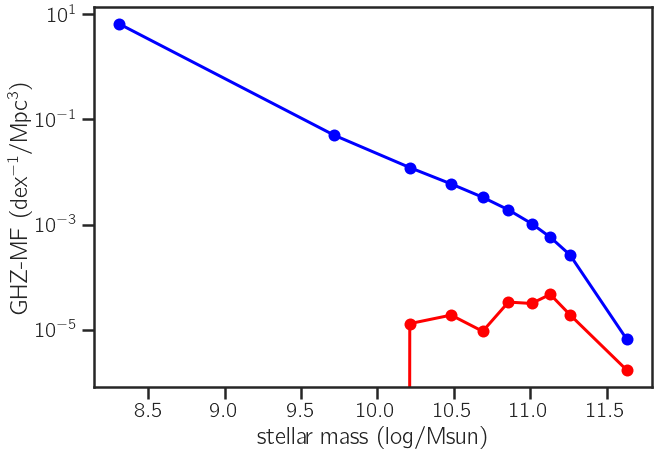

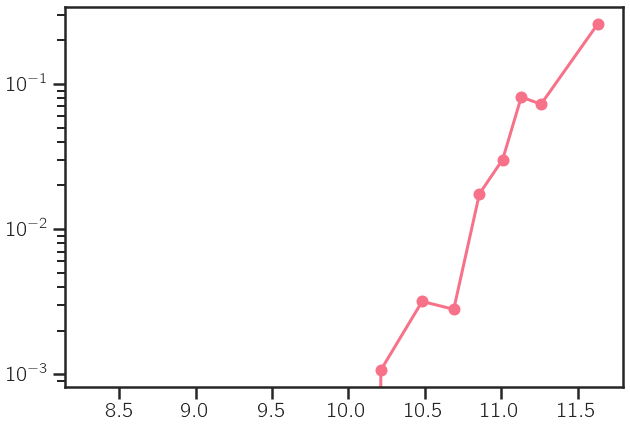

In [15]:
# recover the stellar mass function for CALIFA galaxies
# TODO: revisar IMF, tiene que ser Salpeter (corr ~ +0.21 -- +0.27)
def schechter_fit(log_M, phi_1=4.26e-3, phi_2=0.58e-3, alpha_1=-0.46, alpha_2=-1.58, log_M_0=10.648):
    """Schechter fit from Bladry+2008"""
    M = 10**log_M
    M_0 = 10**log_M_0*1.69
    schechter = np.exp(-M/M_0) * (phi_1*(M/M_0)**alpha_1 + phi_2*(M/M_0)**alpha_2)
    return schechter

data = catalogue

# binning in percentiles to avoid low number statistics
_, bins = pd.qcut(data.mass_star, q=10, retbins=True)

delt = np.diff(bins)

cens = bins[:-1] + delt*0.5
idxs = np.digitize(data.mass_star.values, bins=bins[:-1])
sna_gsmf = np.zeros_like(cens)
for ibin in range(cens.size):
    sna_gsmf[ibin] = 1 / delt[ibin] * np.nansum(data.vcor.values[idxs==ibin+1])

gsmf = schechter_fit(cens)

fac = gsmf / sna_gsmf

plt.figure(figsize=(10,7))
# plt.semilogy(cens, gsmf, "o-")
# plt.semilogy(cens, sna_gsmf, "o-")
plt.semilogy(cens, gsmf, "o-b", label="SNA host candidates")
plt.xlabel("stellar mass (log/Msun)")
plt.ylabel("GHZ-MF (dex$^{-1}$/Mpc$^3$)")

prob_sna_mass = np.zeros_like(cens)
for ibin in range(cens.size):
    prob_sna_mass[ibin] = 1 / delt[ibin] * np.nansum(data.vcor.values[idxs==ibin+1] * data.w_prob_sna[idxs==ibin+1])

plt.semilogy(cens, prob_sna_mass, "o-r", label="PDF of being SNA host in the local universe")

plt.figure(figsize=(10,7))
plt.semilogy(cens, prob_sna_mass / gsmf, "o-", label="fraction of SNA host galaxies")
# USE ONLY IN THE CASE OF USING bins=len(data) =====================================================================================================
# data["new_vcor"] = fac * data.vcor
# plt.figure(figsize=(10,7))
# plt.semilogy(cens, gsmf, "o-r")
# _, bins = pd.qcut(data.mass_star, q=10, retbins=True)
# delt = np.diff(bins)
# cens = bins[:-1] + delt*0.5
# idxs = np.digitize(data.mass_star.values, bins=bins[:-1])
# sna_gsmf = np.zeros_like(cens)
# new_sna_gsmf = np.zeros_like(cens)
# for ibin in range(cens.size):
#     new_sna_gsmf[ibin] = 1 / delt[ibin] * np.nansum(data.new_vcor[idxs==ibin+1])
# plt.semilogy(cens, new_sna_gsmf, "o-b")
# plt.xlabel("stellar mass (log/Msun)")
# plt.ylabel("GSMF (dex$^{-1}$/Mpc$^3$)")

In [16]:
# number of SNAs within the 100Mpc volume in the local universe
N_snas = (10*prob_sna_mass * 4/3 * np.pi * 100**3 * 10**delt).sum()
# number of SNA hosts in the same volume
N_galaxies = (10*(prob_sna_mass)[cens>10.0] * 4/3 * np.pi * 100**3 * 10**delt[cens>10.0]).sum()
print(f"{N_snas}, {N_galaxies:.5e}")

10750.818278682184, 1.07508e+04


6.74076e+00


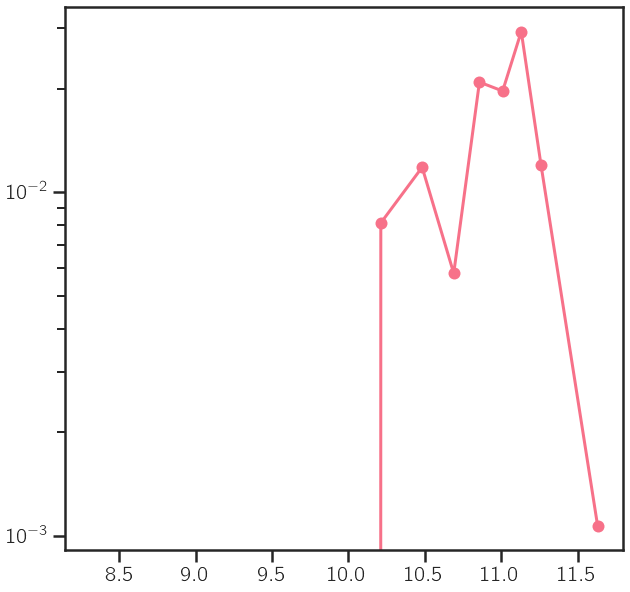

In [17]:
n_sna = np.zeros_like(cens)
for ibin in range(cens.size):
    n_sna[ibin] = 1 / delt[ibin] * np.nansum(data.vcor.values[idxs==ibin+1] * data.w_prob_sna[idxs==ibin+1] * (data[idxs==ibin+1].size))

plt.semilogy(cens, n_sna, "o-")

N_sna_tot = (n_sna * 4/3 * np.pi * 100**3 * 10**delt).sum()
# prob of finding SNA in 100Mpc from 10dex to 11.5dex (local Universe)
print(f"{N_sna_tot/1000/1e4*100:.5e}")

In [18]:
# number of SNAs in MW-like galaxies
(data.n_sna[(data.mass_star>10.)&(data.mass_star<15.5)] / data.n_sna[(data.mass_star>10.)&(data.mass_star<15.5)].size).sum()

7.420074349442379

32.721311475409834

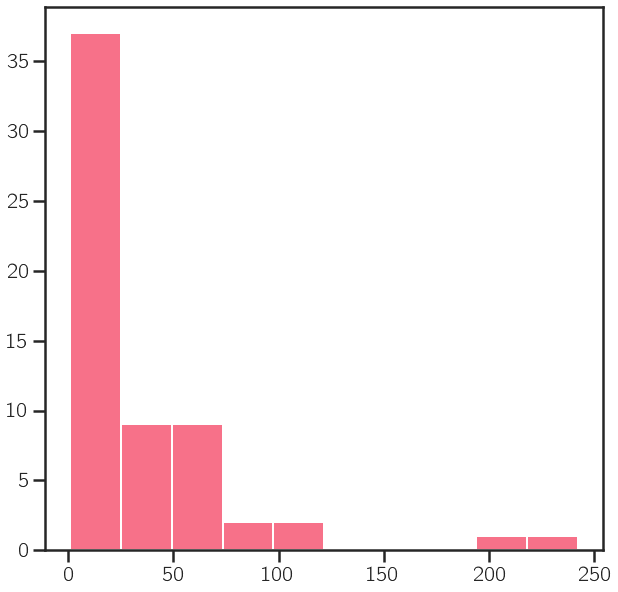

In [19]:
# area de SNAs / area de galaxia
# plt.hist(data.prob_sna[data.prob_sna>0])
# data.prob_sna[data.prob_sna>0].mean()
plt.hist(data.n_sna[data.n_sna>0])
data.n_sna[data.n_sna>0].mean()
# data.n_sna[(data.mass_star>10.75)&(data.mass_star<11.25)].mean()

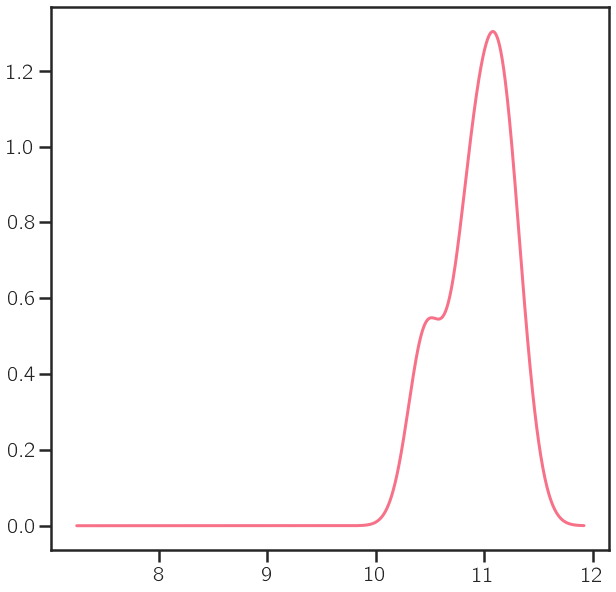

In [24]:
from scipy.stats import gaussian_kde


pdf = gaussian_kde(data.mass_star, weights=data.w_prob_sna)
plt.plot(np.linspace(*data.mass_star.agg(["min","max"]).values, 1000), pdf(x))